In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
cd /content/gdrive/MyDrive/VAEClassifier/

/content/gdrive/MyDrive/VAEClassifier


In [ ]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 32
num_epochs = 20
batch_size = 100
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

# # 10-d latent space, for comparison with non-variational auto-encoder
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        c = capacity
        # self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        # self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        # self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.linear1 = nn.Linear(in_features=latent_dims, out_features=20)
        self.linear2 = nn.Linear(in_features=20, out_features=10)
            
    def forward(self, x):
        # x = self.fc(x)
        # x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        # x = F.relu(self.conv2(x))
        # x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        # return x
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)
    
class VAEClassifier(nn.Module):
    def __init__(self):
        super(VAEClassifier, self).__init__()
        self.encoder = Encoder()
        self.classifier = Classifier()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        y_pred = self.classifier(latent)
        return y_pred #, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(y_pred, y_true): #, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    ce_loss = F.cross_entropy(y_pred, y_true)
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    # kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # return ce_loss + variational_beta * kldivergence
    return ce_loss
    
    

In [ ]:
vae = VAEClassifier()
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)
vae.load_state_dict(torch.load("./VAE_trained_model"))
vae = vae.eval()


In [ ]:
!pip install eagerpy
!pip install foolbox

     |████████████████████████████████| 1.7MB 5.0MB/s 
     |████████████████████████████████| 163kB 20.0MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import time

import eagerpy as ep
import foolbox as fb
import foolbox.attacks as fa
import matplotlib.pyplot as plt
from matplotlib import patches
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from foolbox import PyTorchModel, accuracy, samples, plot, criteria, distances

test_dataset = MNIST(root='./data', download=True, train=False, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

fmodel = fb.PyTorchModel(vae, bounds=(0, 1))
count = 0
for image_batch, image_label in test_dataloader:
    if count==5:
        break
    image_batch = image_batch.to(device)

    # vae classification
    out = fmodel(image_batch)

    y_pred = torch.argmax(out, dim = -1)
    # print("original labels")
    # print(image_label)
    # print("predictions")
    # print(y_pred)
    acc = (y_pred == image_label).float().sum()/batch_size
    print("test accuracy is {:.2f}".format(acc))

    count+=1

test accuracy is 1.00
test accuracy is 0.99
test accuracy is 0.97
test accuracy is 0.99
test accuracy is 0.98


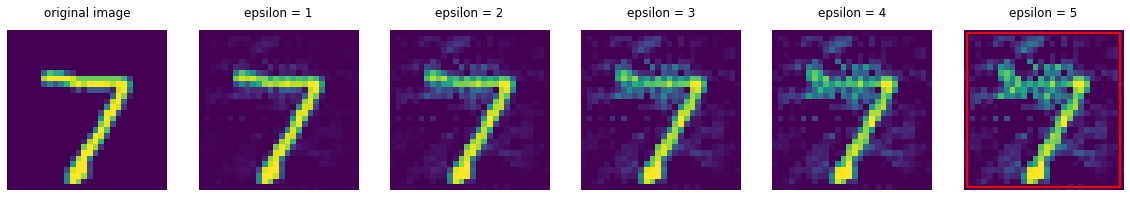

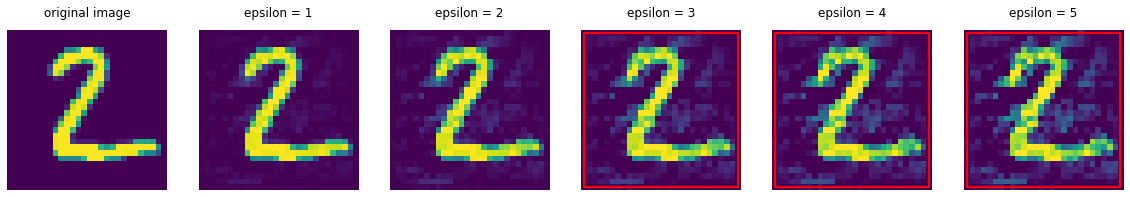

In [ ]:
import time

import numpy as np
import eagerpy as ep
import foolbox as fb
import foolbox.attacks as fa
import matplotlib.pyplot as plt
from matplotlib import patches
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from foolbox import PyTorchModel, accuracy, samples, plot, criteria, distances

# keep num_batch as 1, otherwise the saved images will be overwritten in next batch
num_batch = 1
num_test = 2

test_dataset = MNIST(root='./data', download=True, train=False, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=num_test, shuffle=False)

fmodel = fb.PyTorchModel(vae, bounds=(0, 1))

Linf_epsilons = [
    0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1.0
]
CW_epsilons = [
    0,
    0.1,
    1,
    10,
    100,
    1000
]
L2_epsilons = [
    0,
    1,
    2,
    3,
    4,
    5
]
attacks = [
    # gradient-based attacks
    {"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack(), "epsilons": L2_epsilons},
    # {"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack(), "epsilons": Linf_epsilons},
    # {"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack(),
    #  "epsilons": L2_epsilons},
    # {"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack(),
    #  "epsilons": Linf_epsilons},
    # {"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack(), "epsilons": CW_epsilons},
    # decision-based attacks
    # {"name": "Boundary Attack", "model": fa.BoundaryAttack(), "epsilons": L2_epsilons},
    # {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack(),
    #  "epsilons": Linf_epsilons},
    # {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack(),
    #  "epsilons": L2_epsilons},
    # {"name": "Linear Search Contrast Reduction Attack",
    #  "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf), "epsilons": Linf_epsilons},
    # {"name": "Binary Search Contrast Reduction Attack",
    #  "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf), "epsilons": Linf_epsilons},
    # {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf),
    #  "epsilons": Linf_epsilons}
]

def draw_adversarial_examples():
    for i, attack in enumerate(attacks):
        count = 0
        for images, labels in test_dataloader:
            if count == num_batch:
                break
            images = ep.astensor(images)
            labels = ep.astensor(labels)

            # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
            # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
            # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
            raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=attack["epsilons"])

            plot_images(attack, clipped_adv, is_adv)

            count += 1


def plot_images(attack, clipped_adv, is_adv):
    save_images = False
    model_name = "VAE_Classifier"

    # convert list to tensor: num_epsilon x num_test x channel(1) x width(28) x height(28)
    epsilons = attack["epsilons"]
    num_epsilon = len(epsilons)
    num_test = clipped_adv[0].shape[0]
    clipped_adv_formatted = np.zeros((num_epsilon, num_test, 1, 28, 28))
    for i in range(num_epsilon):
        clipped_adv_formatted[i] = clipped_adv[i].numpy()
    
    is_adv = is_adv.numpy()
    
    for test_id in range(num_test):
        fig, axs = plt.subplots(1, num_epsilon, sharex='col', sharey='row', figsize = (20, 5))
        for eps_id, ax in enumerate(axs.flat):
          image = clipped_adv_formatted[eps_id][test_id]
          image = np.squeeze(image, axis=0)
          ax.matshow(image)
          ax.axis('off')
          title = "original image" if (eps_id==0) else "epsilon = {}".format(epsilons[eps_id])
          ax.set_title(title)
          # draw red border if perturbed image is an adversarial example
          if is_adv[eps_id][test_id]:
              border = patches.Rectangle((0, 0), 27, 27, linewidth=2, edgecolor='r', facecolor='none')
              ax.add_patch(border)
          if save_images:
              plt.savefig("{}-{}-{}.png".format(model_name, attack["name"], test_id))

if __name__ == '__main__':
    draw_adversarial_examples()

KeyboardInterrupt: ignored

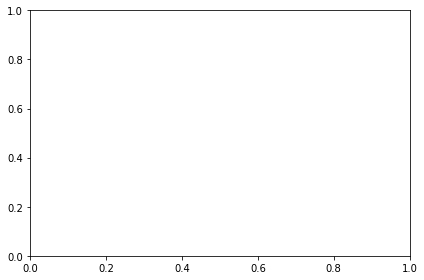

In [ ]:
import time

import eagerpy as ep
import foolbox as fb
import foolbox.attacks as fa
import matplotlib.pyplot as plt
from matplotlib import patches
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from foolbox import PyTorchModel, accuracy, samples, plot, criteria, distances

fmodel = fb.PyTorchModel(vae, bounds=(0, 1))

test_size = 1000  # assuming we are running 1000 tests for each attack
batch_size = 100   # adjust your batch size according to memory limitation, as long as it's a divisor of 1000
num_batch = int(test_size / batch_size)

test_dataset = MNIST(root='./data', download=True, train=False, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Linf_epsilons = [
    0.1,
    0.2,
    0.3,
    0.4,
    0.5
]
CW_epsilons = [
    0.1,
    1,
    10,
    100,
    1000
]
L2_epsilons = [
    1,
    2,
    3,
    4,
    5
]
attacks = [
    # gradient-based attacks
    # {"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack(), "epsilons": L2_epsilons},
    # {"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack(), "epsilons": Linf_epsilons},
    # {"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack(), "epsilons": L2_epsilons},
    # {"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack(), "epsilons": Linf_epsilons},
    {"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack(), "epsilons": CW_epsilons},
    # # # decision-based attacks
    # {"name": "Boundary Attack", "model": fa.BoundaryAttack(), "epsilons": L2_epsilons}, 
    # {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack(), "epsilons": Linf_epsilons},
    # {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack(), "epsilons": L2_epsilons},
    # {"name": "Linear Search Contrast Reduction Attack", "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf), "epsilons": Linf_epsilons}, 
    # {"name": "Binary Search Contrast Reduction Attack", "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf), "epsilons": Linf_epsilons}, 
    # {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf), "epsilons": Linf_epsilons}
]

fig, axs = plt.subplots(len(attacks))
fig.tight_layout()

with open('attack_log2.txt', 'w') as f:
    for i, attack in enumerate(attacks):
        clean_accuracy = torch.zeros(num_batch)
        robust_accuracy_batch = torch.zeros([num_batch, len(L2_epsilons)])
        count = 0
        t1 = time.time()
        for images, labels in test_dataloader:
            if count == num_batch:
                break
            images = ep.astensor(images)
            labels = ep.astensor(labels)

            clean_accuracy[count] = fb.utils.accuracy(fmodel, images, labels)

            # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
            # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
            # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
            raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=attack["epsilons"])

            success_ = is_adv.numpy()
            robust_accuracy_batch[count] = torch.from_numpy(1.0 - success_.mean(axis=-1))

            count += 1

        t2 = time.time()
        # print results
        print(attack)
        print("Clean accuracy: {:.5f}".format(torch.mean(clean_accuracy)))
        print("Average time taken for each test: {} seconds".format((t2 - t1) / test_size))
        robust_accuracy = torch.mean(robust_accuracy_batch, dim=0)
        print("Accuracy with {} attack: {}".format(attack["name"], robust_accuracy))

        # output results to log file
        f.write(str(attack)+"\n")
        f.write("Clean accuracy: {:.5f}".format(torch.mean(clean_accuracy))+"\n")
        f.write("Average time taken for each test: {} seconds".format((t2 - t1) / test_size)+"\n")
        f.write("Accuracy with {} attack: {}".format(attack["name"], robust_accuracy)+"\n\n")

        # plot the robust accuracy against epsilons for the particular attack
        axs[i].set_ylim([0, 1])
        axs[i].plot(attack["epsilons"], robust_accuracy.numpy())
        axs[i].set_title(attack["name"])